In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, auc, f1_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
# function to plot ROC
def roc_auc(pred, act, plot=True, label = "curve"):
    prob = pred/pred.max() #normalize
    fpr, tpr, threshold = roc_curve(act, prob, drop_intermediate=True)    
    a = auc(fpr, tpr)

    if plot:
        plt.scatter(x=fpr, y=tpr, color='navy')
        rcolor = tuple(np.random.rand(3,1)[:,0])
        plt.plot(fpr, tpr, c=rcolor, lw=2, label=label + ' (AUC = %0.3f)' % a)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

    return a

In [4]:
df = pd.read_csv('df_train.csv')
test = pd.read_csv('df_test.csv')
df.shape

(51759, 88)

In [5]:
test.shape # same num of cols as train set

(10013, 88)

#### Features

In [6]:
# patient variables
pat = ['age', 'race_AfricanAmerican', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other',  'gender_0', 'gender_1']
# encounter variables/stats
enc = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'numchange',
       'num_meds']
enc_log = ['number_inpatient_log1p', 'number_emergency_log1p',
       'number_outpatient_log1p']
# encounter medications/changes
med = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'insulin', 'glyburide.metformin', 'glipizide.metformin',
       'glimepiride.pioglitazone', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 
       'change', 'diabetesMed']
# interaction variables
int_var = ['num_medications|time_in_hospital','num_medications|num_procedures',
           'time_in_hospital|num_lab_procedures', 'num_medications|num_lab_procedures',
           'num_medications|number_diagnoses', 'age|number_diagnoses',
           'change|num_medications', 'number_diagnoses|time_in_hospital',
           'num_medications|numchange']
# admission and discharge type/source
adm_dis = ['admission_type_id_3','admission_type_id_4', 'admission_type_id_5',
       'discharge_disposition_id_2', 'discharge_disposition_id_7',
       'discharge_disposition_id_10', 'discharge_disposition_id_18',
       'discharge_disposition_id_19', 'discharge_disposition_id_20',
       'discharge_disposition_id_27', 'discharge_disposition_id_28',
       'admission_source_id_4', 'admission_source_id_7',
       'admission_source_id_8', 'admission_source_id_9',
       'admission_source_id_11']
# labs done
labs = ['max_glu_serum_0', 'max_glu_serum_1',
       'A1Cresult_0', 'A1Cresult_1']
# diagnoses
dia = ['diag_1_1.0', 'diag_1_2.0', 'diag_1_3.0', 'diag_1_4.0', 
       'diag_1_5.0', 'diag_1_6.0', 'diag_1_7.0', 'diag_1_8.0']

In [7]:
# with log values
set_1 = ['age', 'race_AfricanAmerican', 'race_Asian', 'race_Caucasian',
         'race_Hispanic', 'race_Other', 'gender_1', 
         # encounter variables/stats
         'time_in_hospital', 'num_lab_procedures', 'num_procedures',
         'num_medications', 'number_outpatient', 'number_emergency',
         'number_inpatient', 'number_diagnoses', 'numchange', 'num_meds', 
         # medications
         'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
         'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
         'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
         'glyburide.metformin', 'glipizide.metformin', 'glimepiride.pioglitazone', 'metformin.rosiglitazone',
         # admission/discharge
         'admission_type_id_3', 'admission_type_id_4', 'admission_type_id_5',
         
         'discharge_disposition_id_2', 'discharge_disposition_id_7', 
         'discharge_disposition_id_10', 'discharge_disposition_id_18',
         
         'admission_source_id_4', 'admission_source_id_7', 'admission_source_id_8',
         'admission_source_id_9', 'admission_source_id_11',
         
#          'admission_type_id_3', 'admission_type_id_5', 
#          'discharge_disposition_id_2', 'discharge_disposition_id_7',
#          'discharge_disposition_id_10', 'discharge_disposition_id_18',
#          'admission_source_id_4','admission_source_id_7', 'admission_source_id_9', 
         
         # glucose/A1C labs
         'max_glu_serum_0', 'max_glu_serum_1',
         'A1Cresult_0', 'A1Cresult_1',
         
         # interaction variables
         'num_medications|time_in_hospital', 'num_medications|num_procedures',
         'time_in_hospital|num_lab_procedures', 'num_medications|num_lab_procedures',
         'num_medications|number_diagnoses', 'age|number_diagnoses', 
         'change|num_medications', 'number_diagnoses|time_in_hospital', 'num_medications|numchange',
         
         # diagnoses
         'diag_1_1.0', 'diag_1_2.0', 'diag_1_3.0', 'diag_1_4.0',
         'diag_1_5.0','diag_1_6.0', 'diag_1_7.0', 'diag_1_8.0']

In [36]:
feature_1 = ['age', 'time_in_hospital', 'num_procedures', 'num_medications', 'number_outpatient_log1p', 
                 'number_emergency_log1p', 'number_inpatient_log1p', 'number_diagnoses', 
                 
                 'metformin','repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
                 'pioglitazone', 'rosiglitazone', 'acarbose', 'tolazamide', 'insulin', 'glyburide.metformin',
                 
                 'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 
                 'gender_1', 
                 
                 'admission_type_id_3', 'admission_type_id_5', 'discharge_disposition_id_2', 'discharge_disposition_id_7', 
                 'discharge_disposition_id_10', 'discharge_disposition_id_18', 'admission_source_id_4',
                 'admission_source_id_7', 'admission_source_id_9', 
                 
                 'max_glu_serum_0', 'max_glu_serum_1', 'A1Cresult_0',
                 'A1Cresult_1', 
                 
                 'num_medications|time_in_hospital', 'num_medications|num_procedures',
                 'time_in_hospital|num_lab_procedures', 'num_medications|num_lab_procedures', 'num_medications|number_diagnoses',
                 'age|number_diagnoses', 'change|num_medications', 'number_diagnoses|time_in_hospital',
                 'num_medications|numchange', 
                 
                 'diag_1_1.0', 'diag_1_2.0', 'diag_1_3.0', 'diag_1_4.0',
                 'diag_1_5.0','diag_1_6.0', 'diag_1_7.0', 'diag_1_8.0']

In [9]:
feat = list(set(set_1) & set(feature_1))

In [13]:
len(feat)

52

In [11]:
# no log/standardized numerical values
set_2 = ['age', 'race_AfricanAmerican', 'race_Asian', 'race_Caucasian',
         'race_Hispanic', 'race_Other', 'gender_1',
         # encounter variables/stats
         'time_in_hospital', 'num_lab_procedures', 'num_procedures',
         'num_medications', 'number_diagnoses', 
         'numchange', 'num_meds', # number of meds and number of meds changed
         'number_inpatient_log1p', 'number_emergency_log1p', 'number_outpatient_log1p',
         # medications
         'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
         'pioglitazone', 'rosiglitazone', 'acarbose', 'tolazamide', 'insulin',
         'glyburide.metformin', 'glipizide.metformin', 'glimepiride.pioglitazone', 'metformin.rosiglitazone',
         # admission/discharge
         'admission_type_id_1', 'admission_type_id_3', 'admission_type_id_4', 'admission_type_id_5',
         'discharge_disposition_id_1', 'discharge_disposition_id_2', 'discharge_disposition_id_7', 
         'discharge_disposition_id_10', 'discharge_disposition_id_18',
         'discharge_disposition_id_19', 'discharge_disposition_id_20', 'discharge_disposition_id_27', 
         'discharge_disposition_id_28',
         'admission_source_id_1', 'admission_source_id_4', 'admission_source_id_7', 'admission_source_id_8',
         'admission_source_id_9', 'admission_source_id_11', 'admission_type_id_3', 'admission_type_id_5', 
         'discharge_disposition_id_2', 'discharge_disposition_id_7','discharge_disposition_id_10',
         'discharge_disposition_id_18',
         'admission_source_id_4', 'admission_source_id_7', 'admission_source_id_9',
         # glucose/A1C labs
         'max_glu_serum_0', 'max_glu_serum_1',
         'A1Cresult_0', 'A1Cresult_1',
         # interaction variables
         'num_medications|time_in_hospital', 'num_medications|num_procedures',
         'time_in_hospital|num_lab_procedures', 'num_medications|num_lab_procedures',
         'num_medications|number_diagnoses', 'age|number_diagnoses', 
         'change|num_medications', 'number_diagnoses|time_in_hospital', 'num_medications|numchange',
         # diagnoses
         'diag_1_1.0', 'diag_1_2.0', 'diag_1_3.0', 'diag_1_4.0',
         'diag_1_5.0','diag_1_6.0', 'diag_1_7.0', 'diag_1_8.0']

In [12]:
set_2

['age',
 'race_AfricanAmerican',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Other',
 'gender_1',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_diagnoses',
 'numchange',
 'num_meds',
 'number_inpatient_log1p',
 'number_emergency_log1p',
 'number_outpatient_log1p',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'glipizide',
 'glyburide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'tolazamide',
 'insulin',
 'glyburide.metformin',
 'glipizide.metformin',
 'glimepiride.pioglitazone',
 'metformin.rosiglitazone',
 'admission_type_id_1',
 'admission_type_id_3',
 'admission_type_id_4',
 'admission_type_id_5',
 'discharge_disposition_id_1',
 'discharge_disposition_id_2',
 'discharge_disposition_id_7',
 'discharge_disposition_id_10',
 'discharge_disposition_id_18',
 'discharge_disposition_id_19',
 'discharge_disposition_id_20',
 'discharge_disposition_id_27',
 'discharge_disposition_id_28',
 'ad

In [37]:
X_1 = df[feature_1]
y_1 = df['readmitted']

In [38]:
# Create X and y for train and test sets 
X_test1 = test[feature_1]
y_test1 = test['readmitted']

In [68]:
# # Create test train splits for model training
# X_train1, X_dev1, y_train1, y_dev1 = train_test_split(X_1, y_1, test_size=0.20, random_state=42)

In [30]:
# train_2 = df[set_2]
# test_2 = df['readmitted']

In [7]:
# # Create test train splits for model training
# X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.20, random_state=42)

#### Resample from train dataset to address imbalance using under-sampling and over-sampling
- test which gives better scores

In [39]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter(y_1)))
sm = SMOTE(random_state=42)
X_train_new, y_train_new = sm.fit_sample(X_1, y_1)
print('New dataset shape {}'.format(Counter(y_train_new)))

Original dataset shape Counter({0: 47345, 1: 4414})
New dataset shape Counter({0: 47345, 1: 47345})


In [70]:
from imblearn.under_sampling import RandomUnderSampler
print('Original dataset shape {}'.format(Counter(y_train1)))
sm2 = RandomUnderSampler(random_state=42)
X_train_new2, y_train_new2 = sm2.fit_sample(X_train1, y_train1)
print('New dataset shape {}'.format(Counter(y_train_new2)))

Original dataset shape Counter({0: 37885, 1: 3522})
New dataset shape Counter({0: 3522, 1: 3522})


#### Train Models with default parameters

Test with Set 1

In [49]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train_new, y_train_new, test_size=0.20)

In [50]:
rfc = RandomForestClassifier(n_estimators=100)

In [51]:
# logreg = LogisticRegression(fit_intercept=True, penalty='l1')
# print("Cross Validation Score: {:.2%}".format(np.mean(cross_val_score(logreg, X_train, Y_train, cv=10))))
# logreg.fit(X_train, Y_train)

training_start = time.perf_counter()
rfc.fit(X_train_new, y_train_new)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
preds = rfc.predict(X_dev)
prediction_end = time.perf_counter()

acc = accuracy_score(y_dev, preds)
pre = precision_score(y_dev, preds)
rec = recall_score(y_dev, preds)
AUC = roc_auc_score(y_dev, preds)

rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start

print("Accuracy: {:.4%}".format(acc))
print("Precision: {:.4%}".format(pre))
print("Recall: {:.4%}".format(rec))
print("AUC: {}".format(AUC))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Accuracy: 100.0000%
Precision: 100.0000%
Recall: 100.0000%
AUC: 1.0
Time consumed for training: 18.630 seconds
Time consumed for prediction: 0.35052 seconds


In [52]:
print(pd.crosstab(y_dev, preds, margins = True))

col_0     0     1    All
row_0                   
0      9544     0   9544
1         0  9394   9394
All    9544  9394  18938


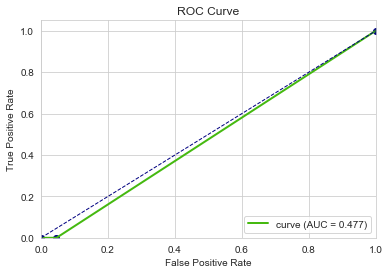

0.47697302697302696

In [53]:
pred = rfc.predict_proba(X_test1.values)[:,1]
fpr, tpr, threshold = roc_curve(y_test1, pred, drop_intermediate=True)    
df_res = pd.DataFrame(data={'fpr':fpr, 'tpr':tpr, 'threshold':threshold})
df_res = df_res[['threshold','fpr','tpr']]
auc(fpr, tpr)

roc_auc(y_test1, p)

In [54]:
p = rfc.predict(X_test1.values)
roc_auc_score(y_test1, p)

0.49994765494137355

In [55]:
print(pd.crosstab(pd.Series(y_test1, name='Actual'), pd.Series(p, name='Predicted'), margins = True))

Predicted      0  1    All
Actual                    
0           9551  1   9552
1            461  0    461
All        10012  1  10013


In [21]:
xgb = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)
eval_set = [(X_train_new, y_train_new), (X_dev.values, y_dev.values)]
eval_metric = ["auc","error"]
%time xgb.fit(X_train_new, y_train_new, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[10:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.81007	validation_0-error:0.259786	validation_1-auc:0.55995	validation_1-error:0.086264
[10:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.89056	validation_0-error:0.155391	validation_1-auc:0.565765	validation_1-error:0.086264
[10:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.925129	validation_0-error:0.118147	validation_1-auc:0.559783	validation_1-error:0.089451
[10:50:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.936702	validation_0-error:0.106045	validation_1-auc:0.565538	validation_1-error:0.093509
[10:50:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_dep

[10:50:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[37]	validation_0-auc:0.959068	validation_0-error:0.065013	validation_1-auc:0.589143	validation_1-error:0.086167
[10:50:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[38]	validation_0-auc:0.959105	validation_0-error:0.065065	validation_1-auc:0.588521	validation_1-error:0.086167
[10:50:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[39]	validation_0-auc:0.959319	validation_0-error:0.065065	validation_1-auc:0.589729	validation_1-error:0.086167
[10:50:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[40]	validation_0-auc:0.959558	validation_0-error:0.064828	validation_1-auc:0.592042	validation_1-error:0.086167
[10:50:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, 

[73]	validation_0-auc:0.960516	validation_0-error:0.064828	validation_1-auc:0.596075	validation_1-error:0.086167
[10:50:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[74]	validation_0-auc:0.960371	validation_0-error:0.064603	validation_1-auc:0.594915	validation_1-error:0.086167
[10:50:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[75]	validation_0-auc:0.960385	validation_0-error:0.06463	validation_1-auc:0.594489	validation_1-error:0.086167
[10:50:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[76]	validation_0-auc:0.960391	validation_0-error:0.064432	validation_1-auc:0.594252	validation_1-error:0.086167
[10:50:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[77]	validation_0-auc:0.960396	validation_0-error:0.064419	validation_1-auc:0.593736	validation_1-err

[10:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[110]	validation_0-auc:0.961156	validation_0-error:0.064089	validation_1-auc:0.599261	validation_1-error:0.086167
[10:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[111]	validation_0-auc:0.961147	validation_0-error:0.063798	validation_1-auc:0.599309	validation_1-error:0.086167
[10:51:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[112]	validation_0-auc:0.961197	validation_0-error:0.063812	validation_1-auc:0.599728	validation_1-error:0.086167
[10:51:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[113]	validation_0-auc:0.961237	validation_0-error:0.063838	validation_1-auc:0.600003	validation_1-error:0.086167
[10:51:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nod

[146]	validation_0-auc:0.9621	validation_0-error:0.063864	validation_1-auc:0.605068	validation_1-error:0.086167
[10:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[147]	validation_0-auc:0.962069	validation_0-error:0.063548	validation_1-auc:0.604675	validation_1-error:0.086167
[10:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[148]	validation_0-auc:0.962099	validation_0-error:0.063719	validation_1-auc:0.604743	validation_1-error:0.086167
[10:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[149]	validation_0-auc:0.962098	validation_0-error:0.063561	validation_1-auc:0.604522	validation_1-error:0.086167
[10:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[150]	validation_0-auc:0.962104	validation_0-error:0.063429	validation_1-auc:0.604374	validation_1

[10:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[183]	validation_0-auc:0.96253	validation_0-error:0.061937	validation_1-auc:0.608843	validation_1-error:0.086167
[10:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[184]	validation_0-auc:0.962546	validation_0-error:0.062056	validation_1-auc:0.60889	validation_1-error:0.086167
[10:51:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[185]	validation_0-auc:0.962563	validation_0-error:0.061911	validation_1-auc:0.608761	validation_1-error:0.086167
[10:51:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[186]	validation_0-auc:0.962561	validation_0-error:0.061819	validation_1-auc:0.608664	validation_1-error:0.086167
[10:51:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes

[219]	validation_0-auc:0.96311	validation_0-error:0.061093	validation_1-auc:0.61078	validation_1-error:0.086167
[10:51:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[220]	validation_0-auc:0.963078	validation_0-error:0.061027	validation_1-auc:0.610462	validation_1-error:0.086167
[10:51:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[221]	validation_0-auc:0.963084	validation_0-error:0.061027	validation_1-auc:0.610641	validation_1-error:0.086167
[10:51:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[222]	validation_0-auc:0.963109	validation_0-error:0.060842	validation_1-auc:0.610794	validation_1-error:0.086167
[10:51:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[223]	validation_0-auc:0.963075	validation_0-error:0.060908	validation_1-auc:0.610509	validation_1

[10:52:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[256]	validation_0-auc:0.963308	validation_0-error:0.05914	validation_1-auc:0.610262	validation_1-error:0.086167
[10:52:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[257]	validation_0-auc:0.963313	validation_0-error:0.059021	validation_1-auc:0.610279	validation_1-error:0.086167
[10:52:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[258]	validation_0-auc:0.963328	validation_0-error:0.059034	validation_1-auc:0.610371	validation_1-error:0.086167
[10:52:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[259]	validation_0-auc:0.963335	validation_0-error:0.058942	validation_1-auc:0.6104	validation_1-error:0.086167
[10:52:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes,

[292]	validation_0-auc:0.96373	validation_0-error:0.057688	validation_1-auc:0.612594	validation_1-error:0.086167
[10:52:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[293]	validation_0-auc:0.963741	validation_0-error:0.057635	validation_1-auc:0.612668	validation_1-error:0.086167
[10:52:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[294]	validation_0-auc:0.963748	validation_0-error:0.057582	validation_1-auc:0.612702	validation_1-error:0.086167
[10:52:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[295]	validation_0-auc:0.963755	validation_0-error:0.057529	validation_1-auc:0.612651	validation_1-error:0.086167
[10:52:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[296]	validation_0-auc:0.963768	validation_0-error:0.057529	validation_1-auc:0.612648	validation_

[10:52:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[329]	validation_0-auc:0.963999	validation_0-error:0.056526	validation_1-auc:0.614039	validation_1-error:0.086167
[10:52:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=4
[330]	validation_0-auc:0.964	validation_0-error:0.056513	validation_1-auc:0.614076	validation_1-error:0.086167
[10:52:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[331]	validation_0-auc:0.964005	validation_0-error:0.05646	validation_1-auc:0.614028	validation_1-error:0.086167
[10:52:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[332]	validation_0-auc:0.96401	validation_0-error:0.05646	validation_1-auc:0.614109	validation_1-error:0.086167
[10:52:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, ma

[365]	validation_0-auc:0.964174	validation_0-error:0.055471	validation_1-auc:0.614429	validation_1-error:0.086167
[10:52:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[366]	validation_0-auc:0.964186	validation_0-error:0.055325	validation_1-auc:0.614466	validation_1-error:0.086167
[10:52:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[367]	validation_0-auc:0.964187	validation_0-error:0.055259	validation_1-auc:0.614532	validation_1-error:0.086167
[10:52:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=4
[368]	validation_0-auc:0.964195	validation_0-error:0.055286	validation_1-auc:0.61464	validation_1-error:0.086167
[10:52:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=4
[369]	validation_0-auc:0.964199	validation_0-error:0.055207	validation_1-auc:0.614526	validatio

[10:53:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[402]	validation_0-auc:0.964379	validation_0-error:0.054085	validation_1-auc:0.614631	validation_1-error:0.086167
[10:53:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[403]	validation_0-auc:0.964386	validation_0-error:0.054032	validation_1-auc:0.614639	validation_1-error:0.086167
[10:53:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[404]	validation_0-auc:0.96439	validation_0-error:0.053979	validation_1-auc:0.614632	validation_1-error:0.086167
[10:53:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[405]	validation_0-auc:0.96439	validation_0-error:0.053953	validation_1-auc:0.614648	validation_1-error:0.086167
[10:53:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes

[438]	validation_0-auc:0.964535	validation_0-error:0.053042	validation_1-auc:0.614524	validation_1-error:0.086167
[10:53:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=4
[439]	validation_0-auc:0.964537	validation_0-error:0.052963	validation_1-auc:0.614532	validation_1-error:0.086167
[10:53:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[440]	validation_0-auc:0.964541	validation_0-error:0.052976	validation_1-auc:0.614451	validation_1-error:0.086167
[10:53:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[441]	validation_0-auc:0.96455	validation_0-error:0.052963	validation_1-auc:0.614567	validation_1-error:0.086167
[10:53:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 10 pruned nodes, max_depth=4
[442]	validation_0-auc:0.964552	validation_0-error:0.052937	validation_1-auc:0.614612	validatio

[10:53:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=4
[475]	validation_0-auc:0.964722	validation_0-error:0.052329	validation_1-auc:0.615196	validation_1-error:0.086167
[10:53:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[476]	validation_0-auc:0.964731	validation_0-error:0.05229	validation_1-auc:0.615255	validation_1-error:0.086167
[10:53:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=4
[477]	validation_0-auc:0.96473	validation_0-error:0.052369	validation_1-auc:0.615163	validation_1-error:0.086167
[10:53:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[478]	validation_0-auc:0.964739	validation_0-error:0.052303	validation_1-auc:0.615266	validation_1-error:0.086167
[10:53:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 10 pruned no

[511]	validation_0-auc:0.964949	validation_0-error:0.051511	validation_1-auc:0.615896	validation_1-error:0.086167
[10:53:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[512]	validation_0-auc:0.964956	validation_0-error:0.051485	validation_1-auc:0.615893	validation_1-error:0.086167
[10:53:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[513]	validation_0-auc:0.964961	validation_0-error:0.051445	validation_1-auc:0.615826	validation_1-error:0.086167
[10:53:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[514]	validation_0-auc:0.964971	validation_0-error:0.051445	validation_1-auc:0.615849	validation_1-error:0.086167
[10:53:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[515]	validation_0-auc:0.964976	validation_0-error:0.051445	validation_1-auc:0.615834	validation

[10:53:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=4
[548]	validation_0-auc:0.96514	validation_0-error:0.050917	validation_1-auc:0.616649	validation_1-error:0.086167
[10:53:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[549]	validation_0-auc:0.965145	validation_0-error:0.050864	validation_1-auc:0.616677	validation_1-error:0.086167
[10:53:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=4
[550]	validation_0-auc:0.965146	validation_0-error:0.050864	validation_1-auc:0.616697	validation_1-error:0.086167
[10:53:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=4
[551]	validation_0-auc:0.965146	validation_0-error:0.050851	validation_1-auc:0.616697	validation_1-error:0.086167
[10:53:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned n

[584]	validation_0-auc:0.965297	validation_0-error:0.050495	validation_1-auc:0.617219	validation_1-error:0.086167
[10:54:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 12 pruned nodes, max_depth=4
[585]	validation_0-auc:0.9653	validation_0-error:0.050495	validation_1-auc:0.617251	validation_1-error:0.086167
[10:54:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[586]	validation_0-auc:0.965306	validation_0-error:0.050495	validation_1-auc:0.617257	validation_1-error:0.086167
[10:54:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[587]	validation_0-auc:0.96531	validation_0-error:0.050495	validation_1-auc:0.617225	validation_1-error:0.086167
[10:54:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[588]	validation_0-auc:0.965312	validation_0-error:0.050495	validation_1-auc:0.617228	validation_1

[10:54:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=4
[621]	validation_0-auc:0.965486	validation_0-error:0.050337	validation_1-auc:0.617848	validation_1-error:0.086167
[10:54:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=4
[622]	validation_0-auc:0.965487	validation_0-error:0.050323	validation_1-auc:0.617804	validation_1-error:0.086167
[10:54:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[623]	validation_0-auc:0.965488	validation_0-error:0.050323	validation_1-auc:0.617766	validation_1-error:0.086167
[10:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[624]	validation_0-auc:0.9655	validation_0-error:0.050323	validation_1-auc:0.617748	validation_1-error:0.086167
[10:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nod

[657]	validation_0-auc:0.965659	validation_0-error:0.049993	validation_1-auc:0.618428	validation_1-error:0.086167
[10:54:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[658]	validation_0-auc:0.965666	validation_0-error:0.049993	validation_1-auc:0.618441	validation_1-error:0.086167
[10:54:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[659]	validation_0-auc:0.965674	validation_0-error:0.049967	validation_1-auc:0.618427	validation_1-error:0.086167
[10:54:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nodes, max_depth=4
[660]	validation_0-auc:0.965679	validation_0-error:0.049954	validation_1-auc:0.618423	validation_1-error:0.086167
[10:54:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 10 pruned nodes, max_depth=4
[661]	validation_0-auc:0.965679	validation_0-error:0.049927	validation_1-auc:0.618421	validatio

[10:54:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=4
[694]	validation_0-auc:0.965863	validation_0-error:0.04969	validation_1-auc:0.61929	validation_1-error:0.086167
[10:54:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[695]	validation_0-auc:0.965869	validation_0-error:0.04969	validation_1-auc:0.619318	validation_1-error:0.086167
[10:54:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=4
[696]	validation_0-auc:0.965872	validation_0-error:0.049677	validation_1-auc:0.619356	validation_1-error:0.086167
[10:54:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 12 pruned nodes, max_depth=4
[697]	validation_0-auc:0.965876	validation_0-error:0.049677	validation_1-auc:0.619348	validation_1-error:0.086167
[10:54:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nod

[730]	validation_0-auc:0.966025	validation_0-error:0.049386	validation_1-auc:0.619896	validation_1-error:0.086167
[10:54:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 12 pruned nodes, max_depth=4
[731]	validation_0-auc:0.966023	validation_0-error:0.049373	validation_1-auc:0.619819	validation_1-error:0.086167
[10:54:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 12 pruned nodes, max_depth=4
[732]	validation_0-auc:0.966029	validation_0-error:0.049373	validation_1-auc:0.619749	validation_1-error:0.086167
[10:55:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[733]	validation_0-auc:0.966033	validation_0-error:0.049373	validation_1-auc:0.619754	validation_1-error:0.086167
[10:55:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 12 pruned nodes, max_depth=4
[734]	validation_0-auc:0.966033	validation_0-error:0.049373	validation_1-auc:0.619757	validat

[10:55:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[767]	validation_0-auc:0.966178	validation_0-error:0.049254	validation_1-auc:0.620616	validation_1-error:0.086167
[10:55:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 10 pruned nodes, max_depth=4
[768]	validation_0-auc:0.966181	validation_0-error:0.049254	validation_1-auc:0.620694	validation_1-error:0.086167
[10:55:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=4
[769]	validation_0-auc:0.966181	validation_0-error:0.049254	validation_1-auc:0.620669	validation_1-error:0.086167
[10:55:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[770]	validation_0-auc:0.966186	validation_0-error:0.049254	validation_1-auc:0.620664	validation_1-error:0.086167
[10:55:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned n

[803]	validation_0-auc:0.966349	validation_0-error:0.049017	validation_1-auc:0.62122	validation_1-error:0.086167
[10:55:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=4
[804]	validation_0-auc:0.966351	validation_0-error:0.049017	validation_1-auc:0.621175	validation_1-error:0.086167
[10:55:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[805]	validation_0-auc:0.966354	validation_0-error:0.049017	validation_1-auc:0.621169	validation_1-error:0.086167
[10:55:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=4
[806]	validation_0-auc:0.966359	validation_0-error:0.049017	validation_1-auc:0.621173	validation_1-error:0.086167
[10:55:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[807]	validation_0-auc:0.966361	validation_0-error:0.048977	validation_1-auc:0.621182	validatio

[10:55:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=4
[840]	validation_0-auc:0.966497	validation_0-error:0.048779	validation_1-auc:0.621957	validation_1-error:0.086167
[10:55:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[841]	validation_0-auc:0.966506	validation_0-error:0.048779	validation_1-auc:0.621966	validation_1-error:0.086167
[10:55:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 10 pruned nodes, max_depth=4
[842]	validation_0-auc:0.96651	validation_0-error:0.048779	validation_1-auc:0.62198	validation_1-error:0.086167
[10:55:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[843]	validation_0-auc:0.966513	validation_0-error:0.048779	validation_1-auc:0.622041	validation_1-error:0.086167
[10:55:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 8 pruned nod

[876]	validation_0-auc:0.966628	validation_0-error:0.048608	validation_1-auc:0.622492	validation_1-error:0.086167
[10:55:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[877]	validation_0-auc:0.966633	validation_0-error:0.048608	validation_1-auc:0.622506	validation_1-error:0.086167
[10:55:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=4
[878]	validation_0-auc:0.966636	validation_0-error:0.048608	validation_1-auc:0.622597	validation_1-error:0.086167
[10:55:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[879]	validation_0-auc:0.966646	validation_0-error:0.048608	validation_1-auc:0.622609	validation_1-error:0.086167
[10:55:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[880]	validation_0-auc:0.966648	validation_0-error:0.048608	validation_1-auc:0.622612	validatio

[10:56:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[913]	validation_0-auc:0.966789	validation_0-error:0.048449	validation_1-auc:0.622957	validation_1-error:0.086167
[10:56:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=4
[914]	validation_0-auc:0.966794	validation_0-error:0.048449	validation_1-auc:0.622988	validation_1-error:0.086167
[10:56:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=4
[915]	validation_0-auc:0.966798	validation_0-error:0.048449	validation_1-auc:0.622995	validation_1-error:0.086167
[10:56:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 8 pruned nodes, max_depth=4
[916]	validation_0-auc:0.966799	validation_0-error:0.048423	validation_1-auc:0.623008	validation_1-error:0.086167
[10:56:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned 

[949]	validation_0-auc:0.966911	validation_0-error:0.048317	validation_1-auc:0.62363	validation_1-error:0.086167
[10:56:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[950]	validation_0-auc:0.966917	validation_0-error:0.048291	validation_1-auc:0.623575	validation_1-error:0.086167
[10:56:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[951]	validation_0-auc:0.96692	validation_0-error:0.048291	validation_1-auc:0.623584	validation_1-error:0.086167
[10:56:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=4
[952]	validation_0-auc:0.966927	validation_0-error:0.048291	validation_1-auc:0.623625	validation_1-error:0.086167
[10:56:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[953]	validation_0-auc:0.966932	validation_0-error:0.048291	validation_1-auc:0.623652	validation_

[10:56:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[986]	validation_0-auc:0.967049	validation_0-error:0.048251	validation_1-auc:0.62438	validation_1-error:0.086167
[10:56:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=4
[987]	validation_0-auc:0.967049	validation_0-error:0.048251	validation_1-auc:0.624391	validation_1-error:0.086167
[10:56:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 12 pruned nodes, max_depth=4
[988]	validation_0-auc:0.967052	validation_0-error:0.048212	validation_1-auc:0.624421	validation_1-error:0.086167
[10:56:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=4
[989]	validation_0-auc:0.967055	validation_0-error:0.048198	validation_1-auc:0.62439	validation_1-error:0.086167
[10:56:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 12 pruned no

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=10, learning_rate=0.01,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.3,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.9)

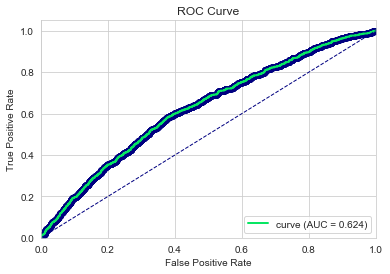

0.6244219228472017

In [58]:
pred = xgb.predict_proba(X_dev1.values)[:,1]
fpr, tpr, threshold = roc_curve(y_dev1, pred, drop_intermediate=True)    
df_res = pd.DataFrame(data={'fpr':fpr, 'tpr':tpr, 'threshold':threshold})
df_res = df_res[['threshold','fpr','tpr']]
auc(fpr, tpr)

roc_auc(pred, y_dev1)

In [22]:
m1 = xgb.feature_importances_
m1

array([0.07575758, 0.01133381, 0.00441422, 0.01145311, 0.00572656,
       0.01014078, 0.00656168, 0.04127893, 0.03221188, 0.04784061,
       0.02278692, 0.0254116 , 0.0001193 , 0.00047721, 0.        ,
       0.00620377, 0.        , 0.02052016, 0.00978287, 0.        ,
       0.00966357, 0.00680029, 0.        , 0.        , 0.        ,
       0.        , 0.03173467, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02839418, 0.01586733, 0.0183727 ,
       0.02338344, 0.00441422, 0.02493438, 0.00835123, 0.01026008,
       0.00703889, 0.0108566 , 0.01288475, 0.01061799, 0.03173467,
       0.00501074, 0.00930566, 0.00608447, 0.00035791, 0.04652828,
       0.00071582, 0.        , 0.04175615, 0.01622524, 0.        ,
       0.00918635, 0.06299213, 0.00572656, 0.00656168, 0.01193033,
       0.        , 0.        , 0.        , 0.0110952 , 0.00608447,
       0.0366261 , 0.        , 0.00059652, 0.        , 0.00083512,
       0.00310189, 0.00906705, 0.00954426, 0.04497733, 0.02028

In [23]:
i1 = pd.DataFrame({'Variable':X_train.columns,
              'Importance': m1}).sort_values('Importance', ascending=False)
i1

,Variable,Importance
0,age,0.075758
56,discharge_disposition_id_2,0.062992
9,diag_3,0.047841
49,race_Caucasian,0.046528
73,diag_1_1.0,0.044977
52,gender_1,0.041756
7,number_inpatient,0.041279
65,admission_source_id_7,0.036626
8,diag_2,0.032212
26,insulin,0.031735


In [2]:
from sklearn.ensemble import RandomForestClassifier # from xgboost import XGBClassifier
model = RandomForestClassifier() # XGBClassifier()
model.fit(X_1, y_1)
pd.DataFrame({'Variable':X_1.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)

NameError: name 'X_1' is not defined

In [53]:
model = XGBClassifier()
model.fit(X_train_new, y_train_new)
pd.DataFrame({'Variable':X_train.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
32,insulin,0.125360
4,discharge_disposition_id,0.103746
13,number_inpatient,0.077810
34,change,0.072046
35,diabetesMed,0.050432
10,num_medications,0.044669
17,number_diagnoses,0.044669
20,metformin,0.041787
16,diag_3,0.037464
2,age,0.031700


#### Randomized Grid Search for Hyperparameter Tuning

In [60]:
import scipy.stats as st
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [65]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

# params = {  
#     "n_estimators": st.randint(3, 40),
#     "max_depth": st.randint(3, 40),
#     "learning_rate": st.uniform(0.05, 0.4),
#     "colsample_bytree": one_to_left,
#     "subsample": one_to_left,
#     "gamma": st.uniform(0, 10),
#     'reg_alpha': from_zero_positive,
#     "min_child_weight": from_zero_positive,
# }

xgb = XGBClassifier(nthreads=-1)  

xgb_params = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
              "max_depth": [ 3, 4, 5, 6, 8, 10, 12, 15],
              "min_child_weight" : [ 1, 3, 5, 7 ],
              "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
              "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
              "subsample": [ 0.3, 0.4, 0.5 , 0.7 ],
              "n_estimators": st.randint(3, 40)}
gs = RandomizedSearchCV(xgb, xgb_params, n_jobs=1)  

training_start = time.perf_counter()
gs.fit(X_train_new, y_train_new)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
preds = gs.predict(X_test.values)
prediction_end = time.perf_counter()

acc = accuracy_score(y_test, preds)
pre = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
AUC = roc_auc_score(y_test, preds)
xgbCV_train_time = training_end-training_start
xgbCV_prediction_time = prediction_end-prediction_start

print(gs.best_params_)
print("Accuracy: {:.4%}".format(acc))
print("Precision: {:.4%}".format(pre))
print("Recall: {:.4%}".format(rec))
print("AUC: {}".format(AUC))
print("Time consumed for training: %4.3f" % (xgbCV_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgbCV_prediction_time))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'colsample_bytree': 0.3, 'gamma': 0.4, 'learning_rate': 0.2, 'max_depth': 15, 'min_child_weight': 3, 'n_estimators': 39, 'subsample': 0.7}
Accuracy: 80.8333%
Precision: 17.3274%
Recall: 17.6497%
AUC: 0.5334961460660407
Time consumed for training: 189.856
Time consumed for prediction: 0.17475 seconds


In [66]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

# params = {  
#     "n_estimators": st.randint(3, 40),
#     "max_depth": st.randint(3, 40),
#     "learning_rate": st.uniform(0.05, 0.4),
#     "colsample_bytree": one_to_left,
#     "subsample": one_to_left,
#     "gamma": st.uniform(0, 10),
#     'reg_alpha': from_zero_positive,
#     "min_child_weight": from_zero_positive,
# }

xgb = XGBClassifier(nthreads=-1)  

xgb_params = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
              "max_depth": [ 3, 4, 5, 6, 8, 10, 12, 15],
              "min_child_weight" : [ 1, 3, 5, 7 ],
              "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
              "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
              "subsample": [ 0.3, 0.4, 0.5 , 0.7 ],
              "n_estimators": st.randint(3, 40)}
gs = RandomizedSearchCV(xgb, xgb_params, n_jobs=1)  

training_start = time.perf_counter()
gs.fit(X_train_new2, y_train_new2)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
preds = gs.predict(X_test.values)
prediction_end = time.perf_counter()

acc = accuracy_score(y_test, preds)
pre = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
AUC = roc_auc_score(y_test, preds)
xgbCV_train_time = training_end-training_start
xgbCV_prediction_time = prediction_end-prediction_start

print(gs.best_params_)
print("Accuracy: {:.4%}".format(acc))
print("Precision: {:.4%}".format(pre))
print("Recall: {:.4%}".format(rec))
print("AUC: {}".format(AUC))
print("Time consumed for training: %4.3f" % (xgbCV_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgbCV_prediction_time))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'colsample_bytree': 0.4, 'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 6, 'subsample': 0.7}
Accuracy: 60.3352%
Precision: 16.6399%
Recall: 61.0254%
AUC: 0.6063542527871861
Time consumed for training: 22.527
Time consumed for prediction: 0.02244 seconds


In [ ]:
#### Boruta

In [ ]:
# load X and y
# NOTE BorutaPy accepts numpy arrays only, hence the .values attribute
X = X_train.values
y = y_train.values
y = y.ravel()

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X, y)

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X)